In [1]:
## -- Importing necessary set of Libraries for the project --

## -- These Libraris import the relevant set of modules and functions for the supervised learning models --

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
## -- Importing relevant set of functions for data analytics and model evaluation --

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression



In [3]:
## -- importing relevant libraries for data preparation and visualization --

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm



In [4]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2

risk_free_rate = 0.05




In [5]:
## -- Definition of relevant functions to compute the Volatility and price of a call option --

def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha*time_to_maturity + true_beta*np.square(moneyness -1)

def call_option_price(moneyness, time_to_maturity, option_vol):
    
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/ (option_vol*np.sqrt(time_to_maturity))
    
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    
    N_d1 = norm.cdf(d1)
    
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

In [6]:
N = 10000

Ks = 1 + 0.25*np.random.randn(N)

Ts = np.random.random(N)

Sigmas = np.array([option_vol_from_surface(k, t) for k, t in zip(Ks, Ts)])

Ps = np.array([call_option_price(k, t, sig) for k, t, sig in zip(Ks, Ts, Sigmas)])

Y = Ps

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1, 1), Sigmas.reshape(-1, 1)], axis= 1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1, 1), X], axis = 1), columns= ['Price', 'Moneyness', 'Time', 'Vol'])

dataset.head()



,Price,Moneyness,Time,Vol
0,0.272873,0.936018,0.972983,0.297708
1,0.111346,1.035155,0.386965,0.238820
2,0.289609,0.817449,0.792678,0.282600
3,0.373936,0.677636,0.796886,0.290080
4,0.345538,0.706273,0.729814,0.281609


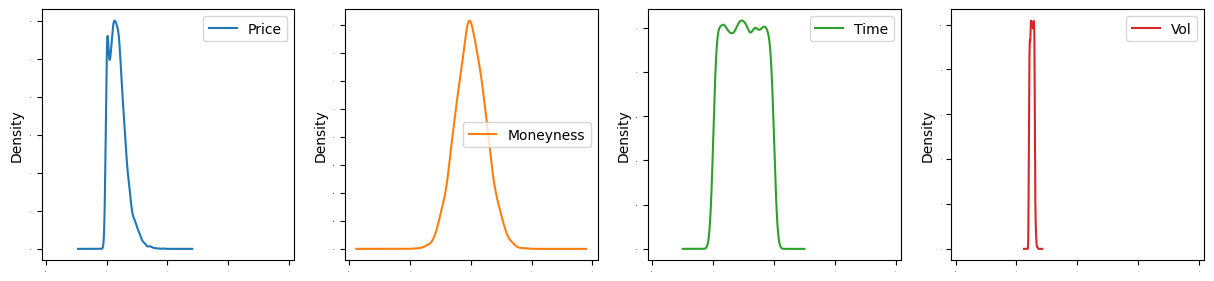

In [13]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

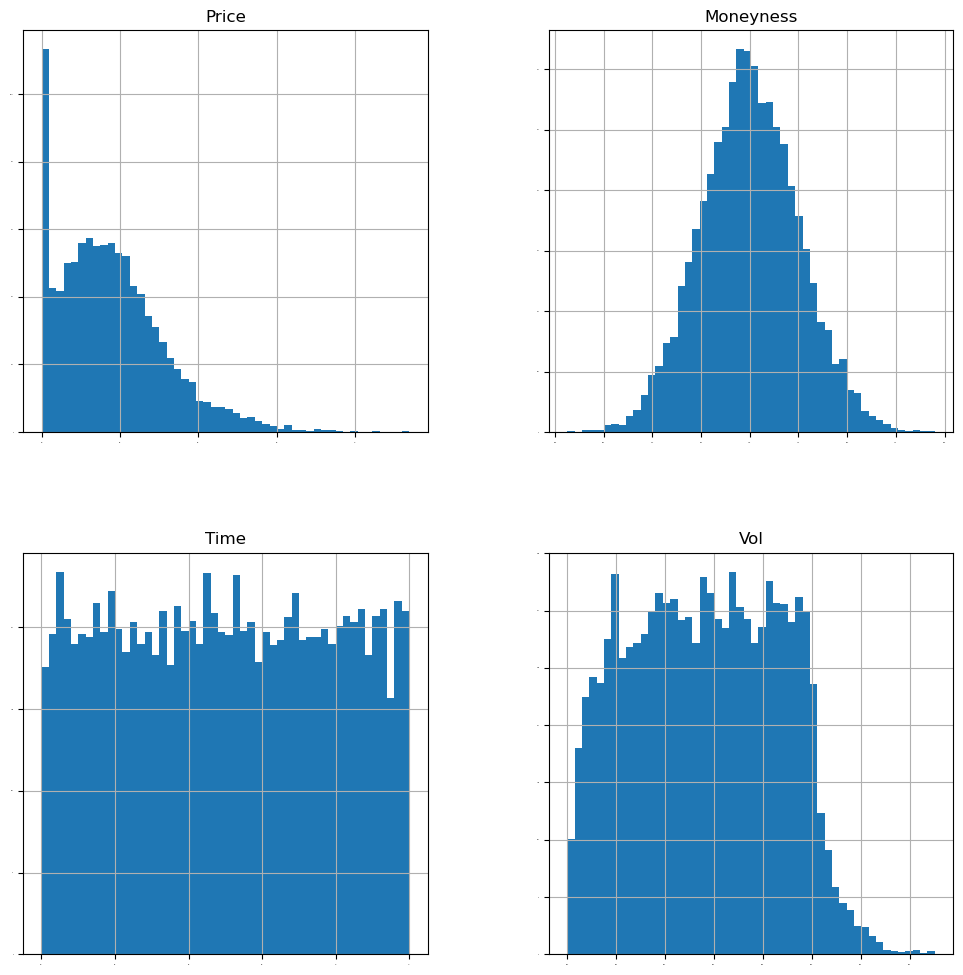

In [14]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

<Figure size 1500x1500 with 0 Axes>

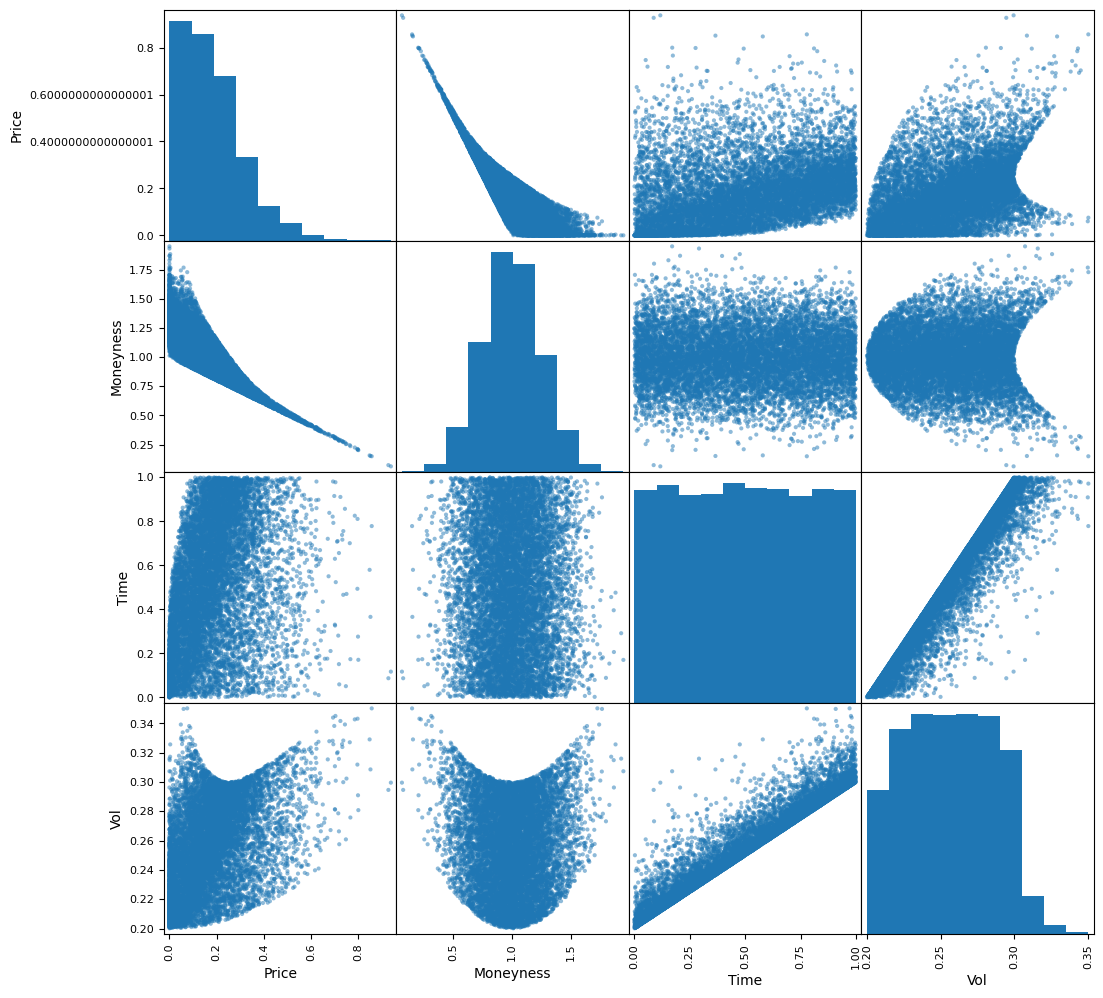

In [7]:
pyplot.figure(figsize = (15, 15))

scatter_matrix(dataset, figsize = (12, 12))

pyplot.show()



In [8]:
bestfeatures = SelectKBest(k = 'all', score_func= f_regression)

fit = bestfeatures.fit(X, Y)

dfscores = pd.DataFrame(fit.scores_)

dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])

## -- Now the two dataframes will be concatenated together

featurescores = pd.concat([dfcolumns, dfscores], axis = 1)

featurescores.columns = ['Specs', 'Score']  ## -- The two column fields are named as 'Specs' and 'Score'

featurescores.nlargest(10, 'Score').set_index('Specs')



,Score
Specs,
Moneyness,30261.248288
Vol,2369.940249
Time,1545.058692


In [10]:
##  -- Splitting the Datasets into a 80- 20 % ratio, which entails that 80 % of the dataset will be used to train the models, while the rest will be for testing --

validation_size = 0.2

train_size = int(len(X)*(1-validation_size))

X_train, X_test = X[0: train_size], X[train_size:len(X)]

Y_train, Y_test = Y[0: train_size], Y[train_size:len(X)]

In [16]:
models = [] ## -- Declaring an empty list of models, whic could be looped over to store the results

models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

models.append(('MLP', MLPRegressor()))

## -- Boosting Methods --

models.append(('ABR', AdaBoostRegressor()))


models.append(('GBR', GradientBoostingRegressor()))

## -- Bagging Methods --

models.append(('RFR', RandomForestRegressor()))

models.append(('ETR', ExtraTreesRegressor()))



In [20]:
names = []

kfold_results = []
test_results = []

train_results = []

num_folds = 10
seed =7
scoring = 'neg_mean_squared_error'


for name, model in models:
    names.append(name)
    ## -- K-fold Analysis:

    kfold = KFold(n_splits= num_folds, random_state= seed, shuffle= True)

    ## Converted mean squared error to positive.
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv = kfold, scoring= scoring)

    kfold_results.append(cv_results)

    ## Full Training Period

    res = model.fit(X_train, Y_train)

    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    ## Test Performance Results

    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)



LR: 0.000347 (0.000027) 0.000346 0.000358
KNN: 0.000019 (0.000009) 0.000011 0.000021
CART: 0.000012 (0.000006) 0.000000 0.000009
SVR: 0.005262 (0.000119) 0.005272 0.005168
MLP: 0.000022 (0.000011) 0.000035 0.000028
ABR: 0.000756 (0.000028) 0.000757 0.000778
GBR: 0.000019 (0.000001) 0.000016 0.000018
RFR: 0.000003 (0.000001) 0.000000 0.000002
ETR: 0.000000 (0.000000) 0.000000 0.000001


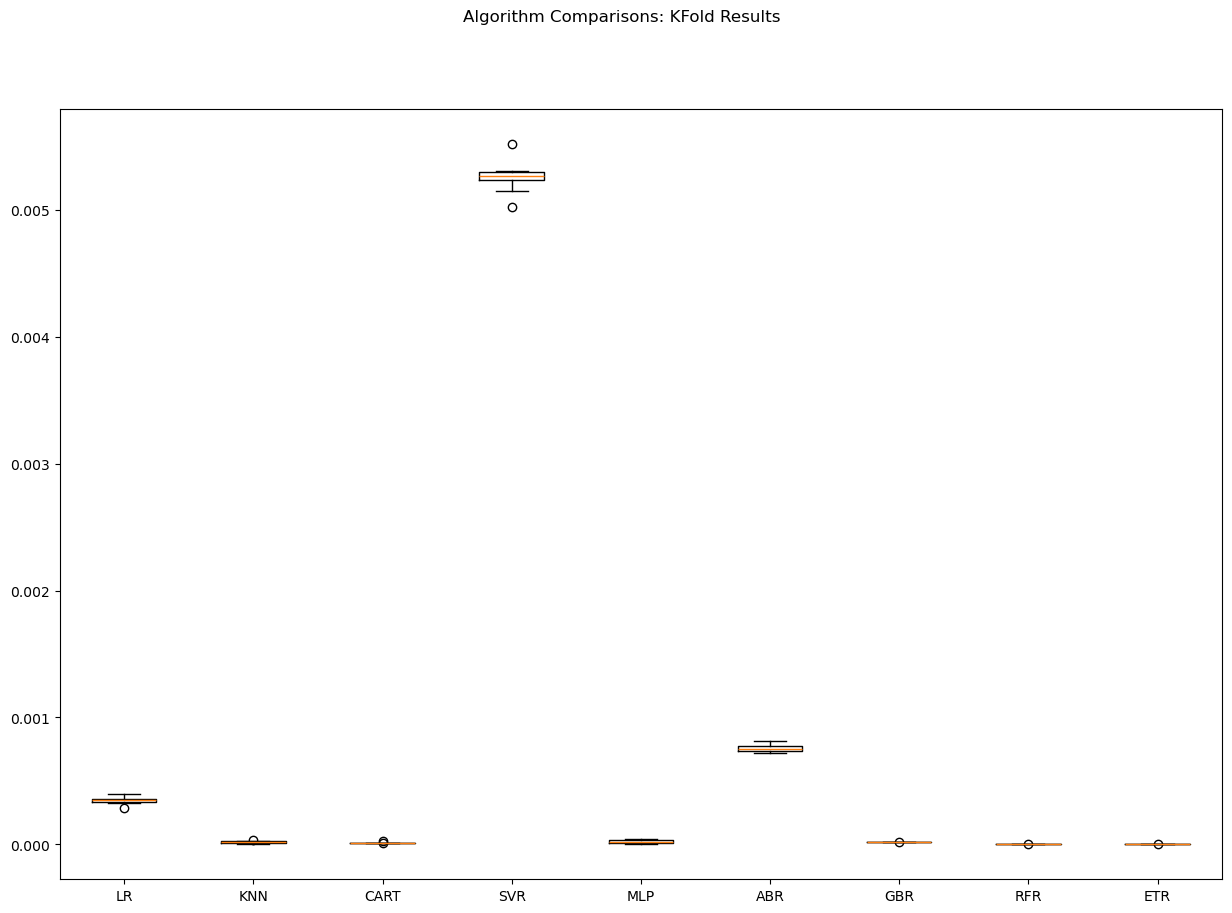

In [21]:
fig = pyplot.figure()

fig.suptitle('Algorithm Comparisons: KFold Results')

ax = fig.add_subplot(111)

pyplot.boxplot(kfold_results)

ax.set_xticklabels(names)

fig.set_size_inches(15, 10)

pyplot.show()


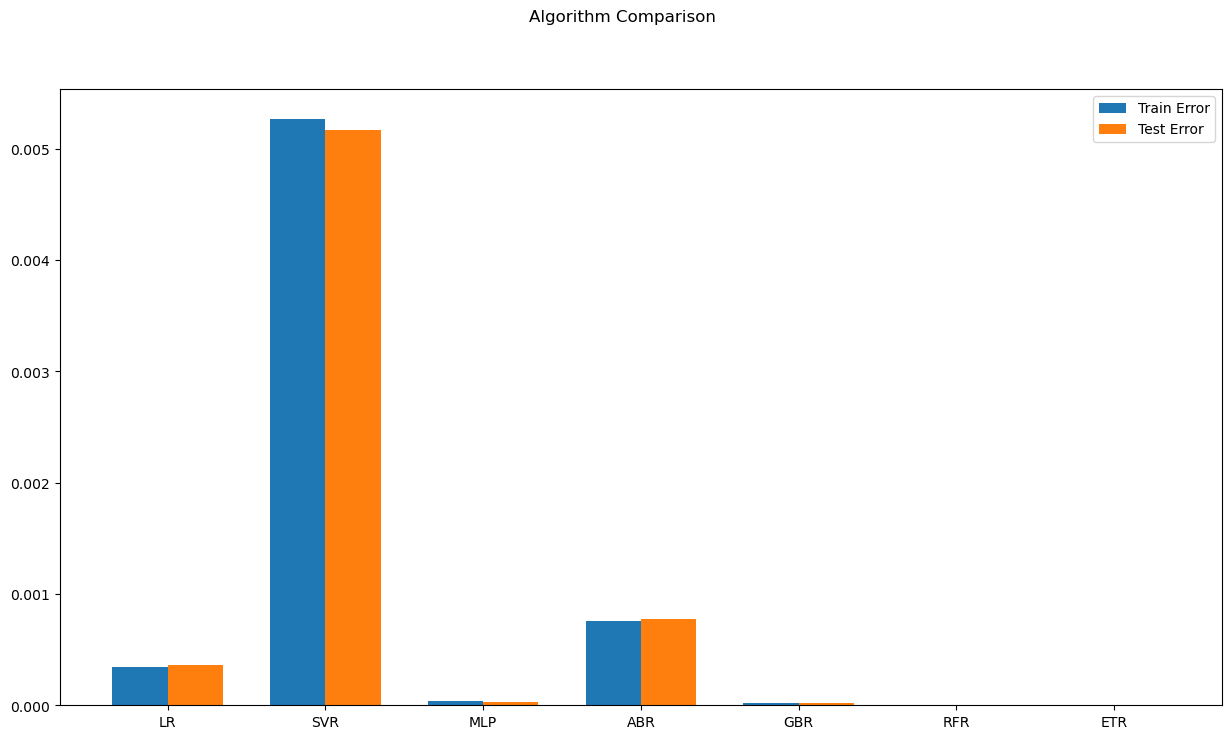

In [23]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()




In [24]:
## -- Going ahead with the MLP Regression Model, as it is indicating promising results

param_grid = {'hidden_layer_sizes': [(20,), (50,), (20, 20), (20, 30, 20)]}

model = MLPRegressor()

kfold = KFold(n_splits= num_folds, random_state= seed, shuffle= True)

grid = GridSearchCV(estimator= model, param_grid= param_grid, scoring= scoring, cv= kfold)

grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

for mean, stddev, param in zip(means, stds, params):
    print("%f (%f) with: %r" %(mean, stddev, param))

    

Best: -0.000041 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000671 (0.000620) with: {'hidden_layer_sizes': (20,)}
-0.000116 (0.000058) with: {'hidden_layer_sizes': (50,)}
-0.000087 (0.000056) with: {'hidden_layer_sizes': (20, 20)}
-0.000041 (0.000023) with: {'hidden_layer_sizes': (20, 30, 20)}


In [26]:
## -- Preparing the model using the Optimized Hyperparameters as obtained

model_tuned = MLPRegressor(hidden_layer_sizes= (20, 30, 20))

model_tuned.fit(X_train, Y_train)


## -- estimation of accuracy on the validation set

predictions = model_tuned.predict(X_test)

print(mean_squared_error(Y_test, predictions))

## -- The Obtained Mean Squared Errors indicate that the fine-tuned MLP Model has a great affinity to the dataset 

7.146486434028482e-06
